In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-dataset/reports.csv
/kaggle/input/cxr-dataset/projections.csv
/kaggle/input/cxr-dataset/images/349_IM-1697-2001.dcm.png
/kaggle/input/cxr-dataset/images/607_IM-2196-1001.dcm.png
/kaggle/input/cxr-dataset/images/2832_IM-1249-2001.dcm.png
/kaggle/input/cxr-dataset/images/699_IM-2263-2001.dcm.png
/kaggle/input/cxr-dataset/images/1931_IM-0602-2001.dcm.png
/kaggle/input/cxr-dataset/images/947_IM-2442-2001.dcm.png
/kaggle/input/cxr-dataset/images/2932_IM-1335-1001.dcm.png
/kaggle/input/cxr-dataset/images/2303_IM-0882-1001.dcm.png
/kaggle/input/cxr-dataset/images/291_IM-1313-2001.dcm.png
/kaggle/input/cxr-dataset/images/1790_IM-0515-1001.dcm.png
/kaggle/input/cxr-dataset/images/3489_IM-1696-2001.dcm.png
/kaggle/input/cxr-dataset/images/3275_IM-1556-1002001.dcm.png
/kaggle/input/cxr-dataset/images/286_IM-1267-3001.dcm.png
/kaggle/input/cxr-dataset/images/3071_IM-1433-1001.dcm.png
/kaggle/input/cxr-dataset/images/1991_IM-0648-1001.dcm.png
/kaggle/input/cxr-dataset/images/3083_

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm
import nltk

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from torchvision import models
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [3]:
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [4]:
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
img_base_dir = '/kaggle/input/cxr-dataset/images'

from PIL import Image
from transformers import BlipForConditionalGeneration, BlipProcessor

# read in the model
processor = BlipProcessor.from_pretrained("nathansutton/generate-cxr")
model = BlipForConditionalGeneration.from_pretrained("nathansutton/generate-cxr")

2024-06-16 23:06:32.948569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 23:06:32.948770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 23:06:33.147670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.68k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [5]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

In [6]:
def generate_report(uid):
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    # your data
    my_image = image_paths[0]
    my_indication = ''

    # process the inputs
    inputs = processor(
        images=Image.open(my_image), 
        text='indication:' + my_indication,
        return_tensors="pt"
    )

    # generate an entire radiology report
    output = model.generate(**inputs,max_length=512)
    report = processor.decode(output[0], skip_special_tokens=True)
    start_idx = report.find("findings")
    end_idx = report.find("impression")
    findings_text = report[start_idx + len("findings :"):end_idx].strip()
    return findings_text
    #return report
    

In [7]:
def compare_report(uid):
    print("Patient UID:", uid)
    
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths)>1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)
    generated_report = generate_report(uid)
    print("Generated Report:", generated_report)

Patient UID: 261


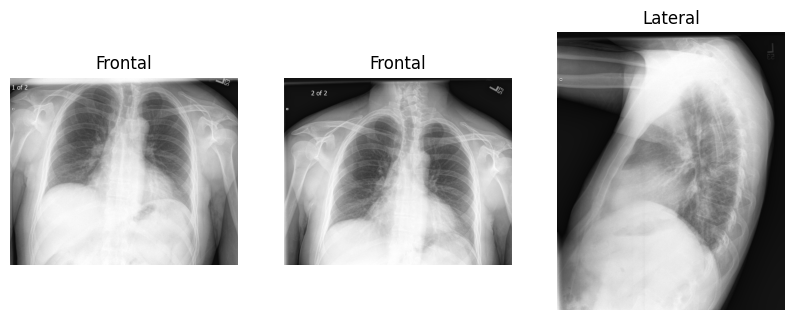

Findings: No focal areas of consolidation. Heart size within normal limits. No pleural effusions. No evidence of pneumothorax. Osseous structures appear intact.
Generated Report: pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen.


In [8]:
compare_report(261)

Patient UID: 3638


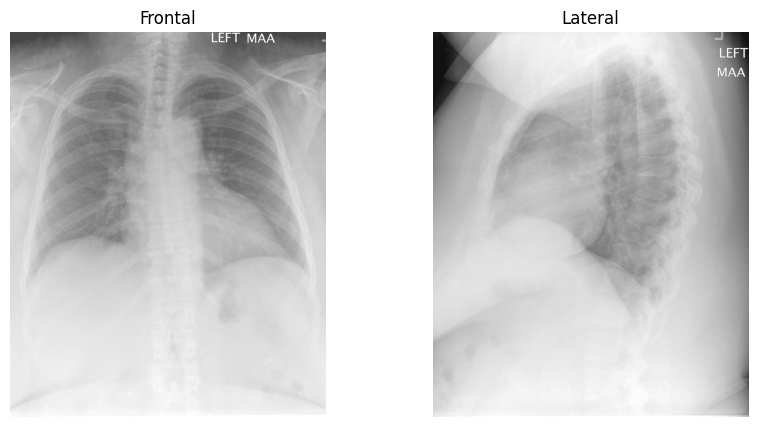

Findings: Cardiomegaly. No pneumothorax or pleural effusion. Clear lung XXXX bilaterally.
Generated Report: the lungs are clear. there is no pneumothorax. the heart and mediastinum are within normal limits. regional bones and soft tissues are unremarkable.


In [9]:
compare_report(3638)

Patient UID: 3892


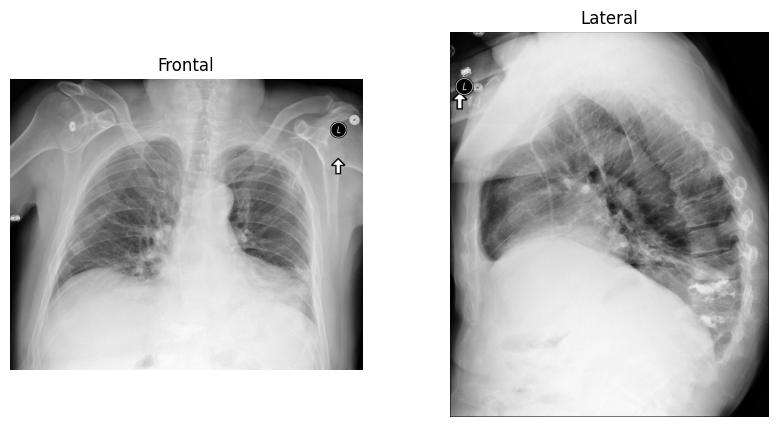

Findings: Normal heart size. Bibasilar patchy opacities, left greater than right. No pneumothorax or large pleural effusions. Left-sided subclavian central venous catheter with tip in the right atrium. No significant pulmonary edema. Low lung volumes. Exaggeration of the thoracic kyphosis with evidence of lower thoracic vertebral body the deep opacities. Multiple mild vertebral body wedge deformities in the mid thoracic spine. Moderate degenerative changes of the thoracic spine. Multiple bilateral rib fractures, some of which appear old. Interval XXXX deformity of the vertebral body XXXX XXXX the level of the two vertebroplasty XXXX.
Generated Report: there is a new left lower lobe opacity. there is also a new right lower lobe opacity. there is no pleural effusion or pneumothorax. the cardiomediastinal silhouette is unremarkable.


In [10]:
compare_report(3892)

Patient UID: 2484


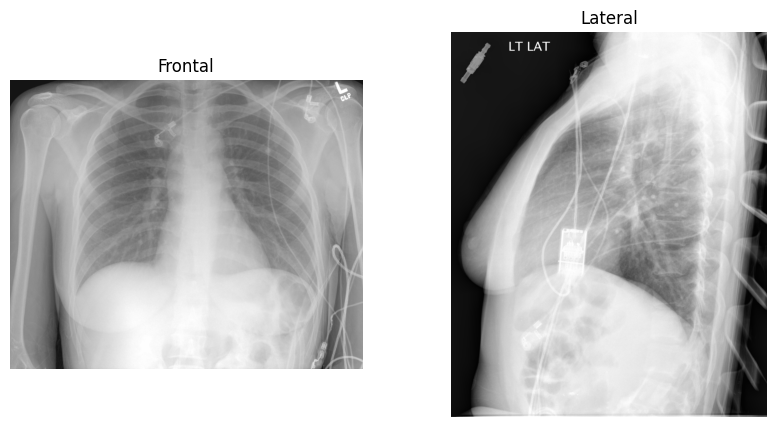

Findings: Frontal and lateral views of the chest with overlying external cardiac monitor leads show normal size and configuration of the cardiac silhouette. There are scattered nodular opacities, XXXX calcified granulomas. No XXXX focal airspace consolidation or pleural effusion.
Generated Report: there is no evidence of tension. there is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. the cardiomediastinal silhouette is within normal limits.


In [11]:
compare_report(np.random.choice(test_uids))

Patient UID: 726


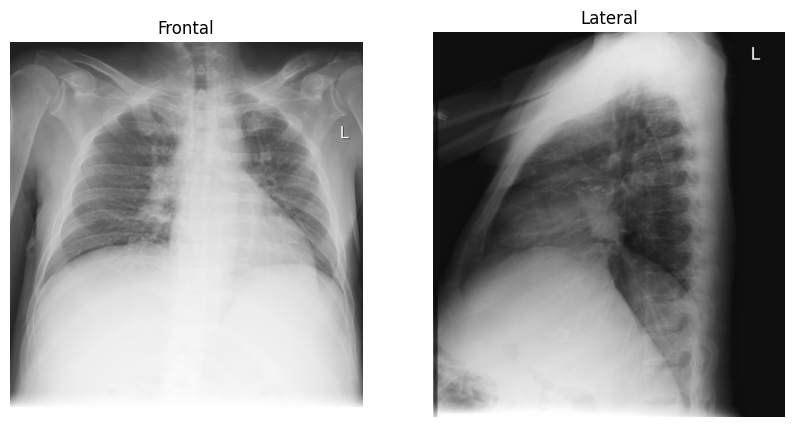

Findings: Heart size within normal limits. Prominent right perihilar density consistent with lymphadenopathy, previously partially demonstrated XXXX abdomen and pelvis XXXX, XXXX. Negative for focal pulmonary consolidation, pleural effusion, or pneumothorax. TIPS noted.
Generated Report: pa and lateral views of the chest provided. there is no focal consolidation. pulmonary vasculature is normal. heart size is normal. mediastinal and hilar contours are normal. there are no pleural effusions.


In [12]:
compare_report(np.random.choice(test_uids))

Patient UID: 212


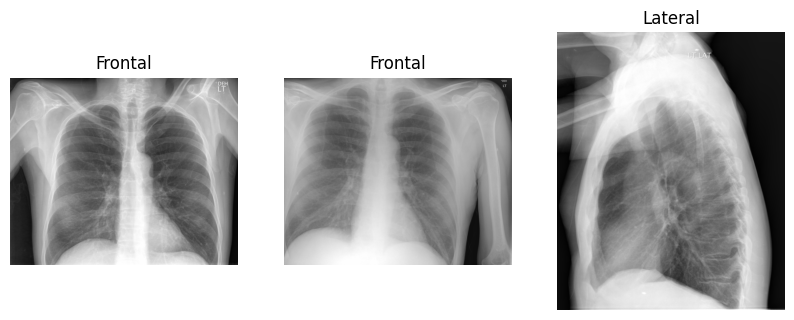

Findings: Chest: Stable cardiomediastinal silhouette. Pulmonary vascularity is within normal limits. Hyperlucent apices. Negative for focal airspace disease or consolidation. Negative for pneumothorax or pleural effusion. Healed remote left 9th rib fracture. Right shoulder: Negative for fracture or dislocation.
Generated Report: the lungs are clear. there is no pneumothorax. the heart and mediastinum are within normal limits. regional bones and soft tissues are unremarkable.


In [13]:
compare_report(np.random.choice(test_uids))

Patient UID: 2830


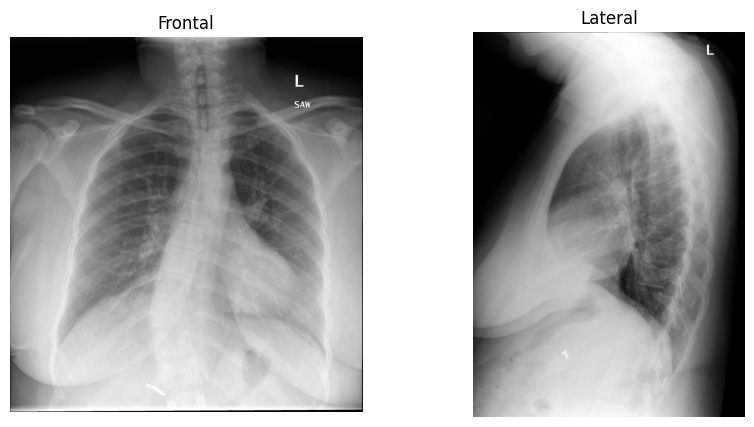

Findings: nan
Generated Report: the lungs are clear. the cardiomediastinal silhouette is within normal limits. no acute osseous abnormalities.


In [14]:
compare_report(np.random.choice(test_uids))

Patient UID: 3184


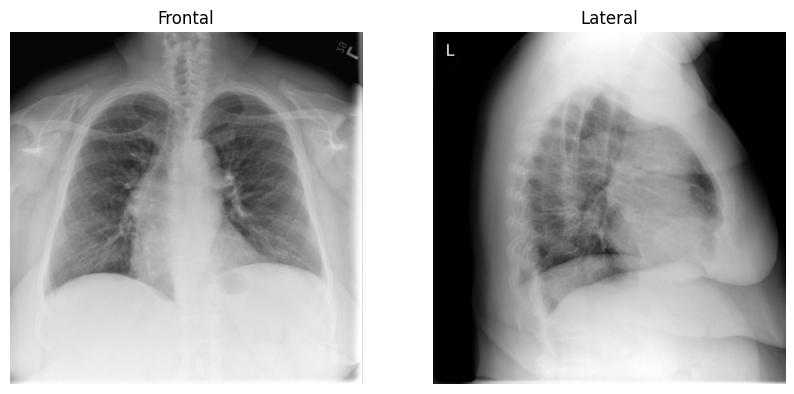

Findings: The aortic XXXX is mildly tortuous. The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. There are T-spine osteophytes. Large body habitus.
Generated Report: the lungs are clear. there is no pneumothorax. the heart and mediastinum are within normal limits. regional bones and soft tissues are unremarkable.


In [15]:
compare_report(np.random.choice(test_uids))